In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import iv, kv
from PIL import Image

In [2]:
# Bessel 1st kind modified functions
I0 = lambda x: iv(0, x)
I1 = lambda x: iv(1, x)

# Bessel 2nd kind modified functions
K0 = lambda x: kv(0, x)
K1 = lambda x: kv(1, x)

In [3]:
def load_constants():
    return Image.open('constants-a.png')

In [43]:
M = 10
m = 1.5
# J = 2 * pow(M, 2) / (1 + pow(m, 2)) # placeholder for A^2
# A = np.sqrt(J)
r1 = 0.5
# b = 0.1
# a2 = 0.4
phi = 0.2 #b / a2
q0, q1 = 0.2, 0.4
omega = 10

def J(M=M, m=m):
    return 2 * pow(M, 2) / (1 + pow(m, 2))

def A(M=M, m=m):
    return np.sqrt(J(M=M, m=m))

@np.vectorize
def r2(z=0.5, phi=phi):
    """outer cylinder radius equation"""
    return 1 + phi * np.math.cos(2 * np.math.pi * z)

@np.vectorize
def q(t, omega=omega):
    return q0 + q1 * np.math.sin(omega * t)

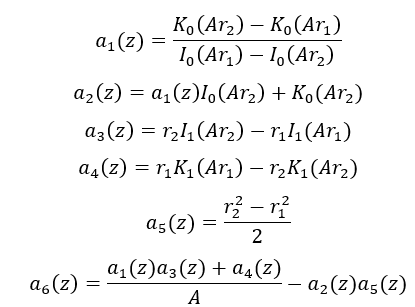

In [44]:
load_constants()

In [45]:
@np.vectorize
def a1(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    part_1 = K0(A(M=M, m=m) * r2z) - K0(A(M=M, m=m) * r1)
    part_2 = I0(A(M=M, m=m) * r1) - I0(A(M=M, m=m) * r2z)
    return part_1 / part_2

@np.vectorize
def a2(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return a1(z, M=M, m=m) * I0(A(M=M, m=m) * r2z) + K0(A(M=M, m=m) * r2z)

@np.vectorize
def a3(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r2z * I1(A(M=M, m=m) * r2z) - r1 * I1(A(M=M, m=m) * r1)

@np.vectorize
def a4(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r1 * K1(A(M=M, m=m) * r1) - r2z * K1(A(M=M, m=m) * r2z)

@np.vectorize
def a5(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return (pow(r2z, 2) - pow(r1, 2)) / 2

@np.vectorize
def a6(z=0.5, phi=phi, M=M, m=m):
    part_1 = a1(z, phi=phi, M=M, m=m) * a3(z, phi=phi, M=M, m=m) + a4(z, phi=phi, M=M, m=m)
    part_2 = a2(z, phi=phi, M=M, m=m) * a5(z, phi=phi, M=M, m=m)
    return part_1 / A(M=M, m=m) - part_2

In [49]:
@np.vectorize
def dpdz(z=0.5, t=1, phi=phi, M=M, m=m, omega=omega, q_v=None):
#     return 1
    if q_v is None:
        q_v = q(t, omega=omega)
    part_1 = q_v / (4 * np.math.pi)
    part_2 = a5(z, phi=phi, M=M, m=m) / 2
    part_3 = J(M=M, m=m) * a2(z, phi=phi, M=M, m=m) / a6(z, phi=phi, M=M, m=m)
    return (part_1 - part_2) * part_3

In [47]:
nz = 10
nt2 = 100
zs = np.linspace(0, 1, nz)
ts2 = np.linspace(0, 2, nt2)
dps = np.zeros((nz, nt2))

for (i, ti) in enumerate(ts2):
    for (j, zj) in enumerate(zs):
        dps[j, i] = dpdz(z=zj, t=ti)

In [48]:
df2 = pd.DataFrame(dps).transpose()
df2.head(2)

,0,1,2,3,4,5,6,7,8,9
0,45.528718,47.063014,52.719633,65.481291,82.843281,82.843281,65.481291,52.719633,47.063014,45.528718
1,44.496043,45.879877,50.940447,62.110852,76.722570,76.722570,62.110852,50.940447,45.879877,44.496043


In [51]:
dps2 = np.zeros((nz, nt2))

for (i, ti) in enumerate(ts2):
    dps2[:, i] = dpdz(z=zs, t=ti)

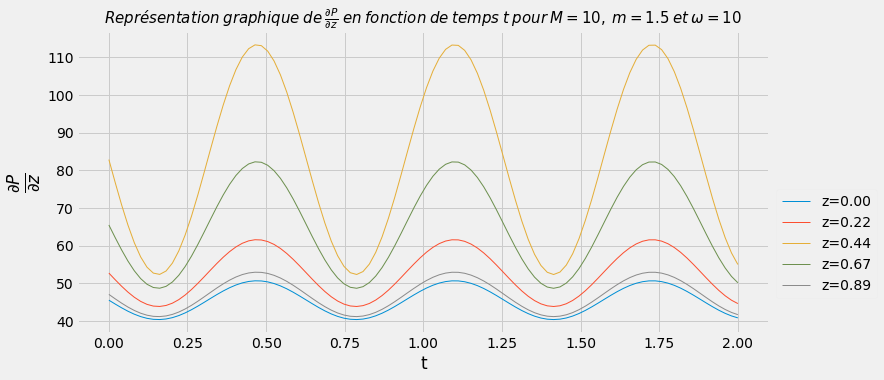

In [54]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nz, 2):
        z = zs[i]
        plt.plot(ts2, dps[i, :], label=f'z={z:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    frac = r'\frac{\partial P}{\partial z}'
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    sp = r'\hspace{0.25}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}{frac}{sp}en{sp}fonction{sp}de{sp}temps{sp}t{sp}pour{sp}M=10,{sp}m=1.5{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-nil.png', transparent=True)

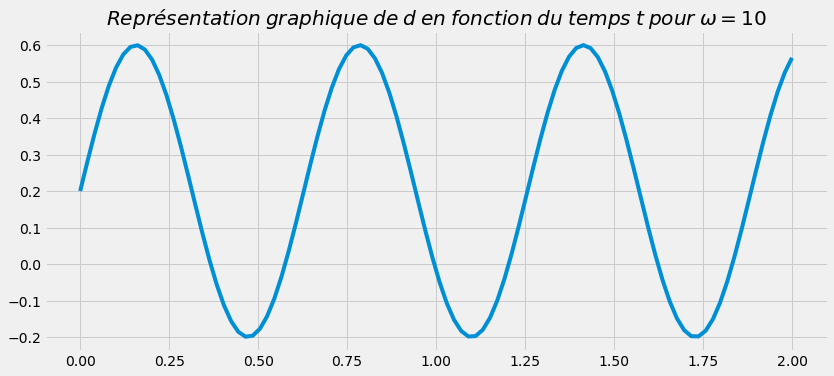

In [24]:
with plt.style.context('fivethirtyeight'):
    plt.plot(ts2, q(ts2))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    t = fr'$Représentation{sp}graphique{sp}de{sp}d{sp}en{sp}fonction{sp}du{sp}temps{sp}t{sp}pour{sp}\omega=10$'
    plt.title(t)

In [58]:
q_v=np.arange(-0.5, 0.5, 0.1)
dpsq_1 = dpdz(q_v=q_v, M=1)
dpsq_2 = dpdz(q_v=q_v, M=10)
dpsq_3 = dpdz(q_v=q_v, M=20)

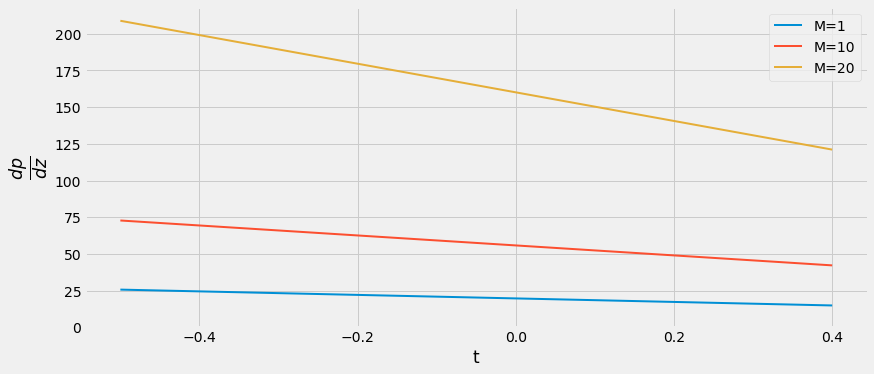

In [59]:
with plt.style.context('fivethirtyeight'):
    plt.plot(q_v, dpsq_1, linewidth=2, label='M=1')
    plt.plot(q_v, dpsq_2, linewidth=2, label='M=10')
    plt.plot(q_v, dpsq_3, linewidth=2, label='M=20')
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend()
    plt.ylim(bottom=0)
    plt.xlabel('t')
    plt.ylabel(r'$\frac{dp}{dz}$', fontsize=25)

In [27]:
@np.vectorize
def c2(z=0.5, t=1, phi=phi, M=M, m=m, omega=omega):
    part_1 = 2 * dpdz(z=z, t=t, phi=phi, M=M, m=m, omega=omega)
    part_2 = a2(z, phi=phi, M=M, m=m) * J(M=M, m=m)
    return part_1 / part_2

@np.vectorize
def c1(z=0.5, t=1, phi=phi, M=M, m=m):
    return a1(z, phi=phi, M=M, m=m) * c2(z=z, t=t, phi=phi, M=M, m=m)

In [57]:
@np.vectorize
def w(r, z=0.5, t=1, phi=phi, M=M, m=m, omega=omega):
    part_1 = c1(z, t, phi=phi, M=M, m=m) * I0(A(M=M, m=m) * r)
    part_2 = c2(z, t, phi=phi, M=M, m=m) * K0(A(M=M, m=m) * r)
    part_3 = 2 * dpdz(z, t, phi=phi, M=M, m=m, omega=omega) / J(M=M, m=m)
#     return part_1 + part_2 - part_3 - 1
    # using -dpdz
    return part_1 + part_2 - part_3 - 1

In [58]:
nr = 50
nt = 50
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws = np.zeros((50, 50))

for (i, ti) in enumerate(ts):
    ws[:, i] = w(r=rs, t=ti)

In [59]:
df_1 = pd.DataFrame(ws).transpose()
df_1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.0,-1.116694,-1.225819,-1.327730,-1.422762,-1.511226,-1.593412,-1.669591,-1.740016,-1.804920,...,-1.741274,-1.677713,-1.609778,-1.537345,-1.460279,-1.378434,-1.291656,-1.199777,-1.102621,-1.0
1,-1.0,-1.076102,-1.147267,-1.213729,-1.275704,-1.333396,-1.386993,-1.436673,-1.482601,-1.524928,...,-1.483421,-1.441970,-1.397666,-1.350429,-1.300171,-1.246796,-1.190203,-1.130285,-1.066924,-1.0


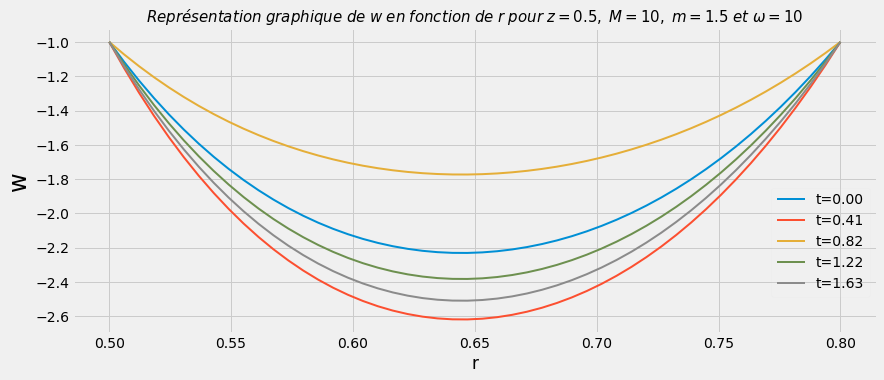

In [60]:
with plt.style.context('fivethirtyeight'):
    for i in range(5):
        t = ts[i * 2]
        plt.plot(rs, ws[:, i * 2], label=f't={t:.2f}', linewidth=2)
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    sp = r'\hspace{0.3}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}w{sp}en{sp}fonction{sp}de{sp}r{sp}pour{sp}z=0.5,{sp}M=10,{sp}m=1.5{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/axial-velocity-newtonian-beta-nil.png', transparent=True)

In [69]:
# axial velocity profile with different values of Hartmann number
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_1 = w(rs, M=pow(10, -6))
ws_2 = w(rs, M=1)
ws_3 = w(rs, M=10)
ws_4 = w(rs, M=100)

In [70]:
ws_5 = w(rs, M=20)
ws_6 = w(rs, M=50)
ws_7 = w(rs, M=80)

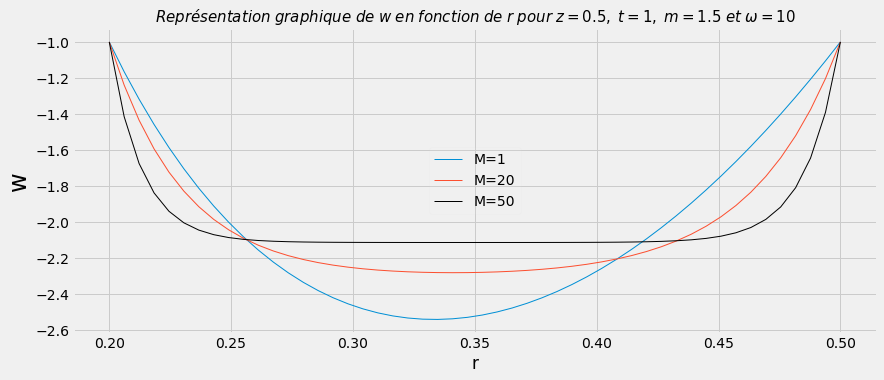

In [117]:
with plt.style.context('fivethirtyeight'):
    # plots
    plt.plot(rs, ws_2, linewidth=1, label='M=1')
    plt.plot(rs, ws_5, linewidth=1, label='M=20')
    plt.plot(rs, ws_6, linewidth=1, label='M=50', color='black')    
    
    # setting figure size
    plt.gcf().set_size_inches(12.5, 5.5)
    
    # labels
    plt.legend(loc='upper center', framealpha=0.1)
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    
    # title
    sp = r'\hspace{0.3}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}w{sp}en{sp}fonction{sp}de{sp}r{sp}pour{sp}z=0.5,{sp}t=1,{sp}m=1.5{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-nil-hartmann.png', transparent=True)

In [100]:
# axial velocity profile with different values of Hall parameter
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_m_1 = w(rs, m=0)
ws_m_2 = w(rs, m=1.5)
ws_m_3 = w(rs, m=10)
# ws_m_4 = w(rs, m=100)

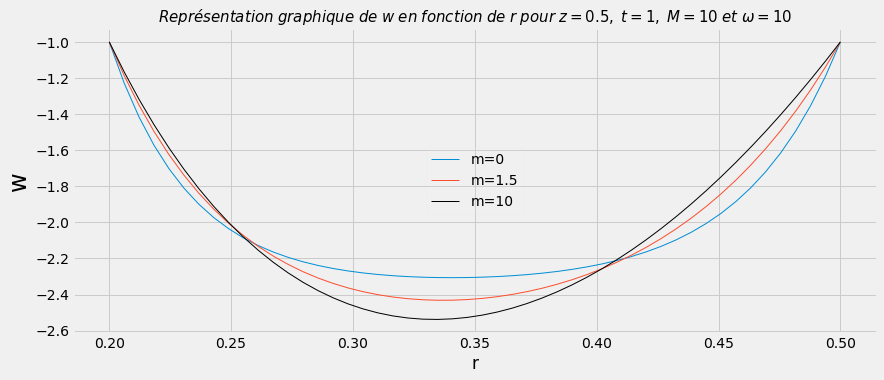

In [116]:
with plt.style.context('fivethirtyeight'):
    # plots
    plt.plot(rs, ws_m_1, linewidth=1, label='m=0')
    plt.plot(rs, ws_m_2, linewidth=1, label='m=1.5')
    plt.plot(rs, ws_m_3, linewidth=1, label='m=10', color='black')
#     plt.plot(rs, ws_m_4, linewidth=1, label='M=50')
    
    # setting figure size
    plt.gcf().set_size_inches(12.5, 5.5)
    
    # labels
    plt.legend(loc='upper center', framealpha=0.1)
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    
    # title
    sp = r'\hspace{0.3}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}w{sp}en{sp}fonction{sp}de{sp}r{sp}pour{sp}z=0.5,{sp}t=1,{sp}M=10{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-nil-hall.png', transparent=True)

In [62]:
from scipy.integrate import simps

In [74]:
@np.vectorize
def y(q=1, z=0.5, phi=phi):
    return (q / (4 * np.math.pi) - a5(z, phi=phi) / 2) * J() * a2(z, phi=phi) / a6(z, phi=phi)

nq = 20
qs = np.linspace(-1, 1, nq)
zs = np.linspace(0, 1, 100)

In [75]:
# occlusion=0.1
delta_p_1 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.1)
    delta_p_1[i] = simps(ys, zs)

In [76]:
# occlusion=0.2
delta_p_2 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.2)
    delta_p_2[i] = simps(ys, zs)

In [78]:
# occlusion=0.3
delta_p_3 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.3)
    delta_p_3[i] = simps(ys, zs)

In [80]:
# occlusion=0.4
delta_p_4 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.4)
    delta_p_4[i] = simps(ys, zs)

In [83]:
# occlusion=0.8
delta_p_8 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.8)
    delta_p_8[i] = simps(ys, zs)

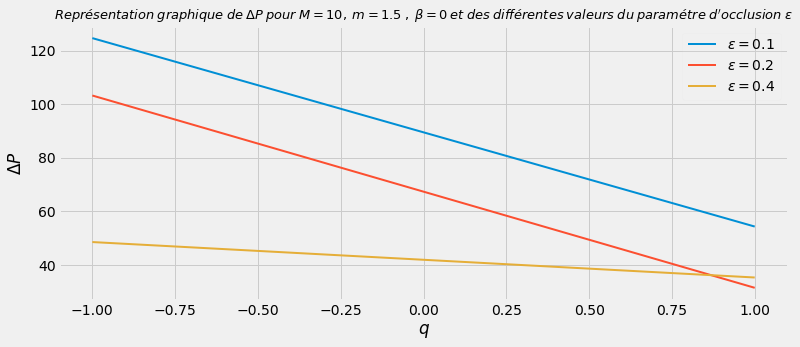

In [89]:
with plt.style.context('fivethirtyeight'):
    plt.plot(qs, delta_p_1, linewidth=2, label=r'$\epsilon=0.1$')
    plt.plot(qs, delta_p_2, linewidth=2, label=r'$\epsilon=0.2$')
#     plt.plot(qs, delta_p_3, linewidth=2, label=r'$\epsilon=0.3$')
    plt.plot(qs, delta_p_4, linewidth=2, label=r'$\epsilon=0.4$')
#     plt.plot(qs, delta_p_8, linewidth=2, label=r'$\epsilon=0.8$')
#     plt.gca().invert_yaxis()
    plt.xlabel('$q$')
    plt.ylabel('$\Delta P$')
    sp = r'\hspace{0.25}' # 
    ttl = fr"$Représentation{sp}graphique{sp}de{sp}\Delta P{sp}pour{sp}M=10,{sp}m=1.5{sp},{sp}\beta=0{sp}et{sp}des{sp}différentes{sp}valeurs{sp}du{sp}paramétre{sp}d'occlusion{sp}\epsilon$"
    plt.title(ttl, fontsize=13)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1)
    plt.savefig('figs/newtonian-pressure-drop-beta-nil.png', transparent=True, dpi=100)